# WLS - Code Examples Part 2

When the `sigma` argument is not provided to `scipy.optimize.curve_fit`, the function performs an **unweighted least-squares fit**. This is mathematically equivalent to assuming the standard deviation ($\sigma_i$) for every data point is equal to 1.

This leads to two different ways to answer your question, depending on what you mean by "calculate chi-squared."

1.  **Can we calculate a formal, statistically rigorous Chi-Squared (`χ²`) for a goodness-of-fit test?**
    *   **Answer: No.** A formal chi-squared test requires that you have **known, independent experimental uncertainties (`σᵢ`)** for each of your data points (`yᵢ`). The entire purpose of the test is to determine if the scatter of your data around the fitted model is consistent with your *a priori* knowledge of the measurement errors.
    *   The formula for a true chi-squared statistic is:
        $$ \chi^2 = \sum_{i=1}^{n} \left( \frac{y_i - f(x_i)}{\sigma_i} \right)^2 $$
    *   Since you don't have the `σᵢ` values, you cannot perform this formal test.

2.  **Can we calculate a *value* that is related to Chi-Squared to help us evaluate the fit?**
    *   **Answer: Yes, absolutely.** This is where your insight about `sigma=1` is crucial.
    *   When `curve_fit` assumes `σᵢ = 1` for all points, the quantity it is minimizing is:
        $$ \sum_{i=1}^{n} \left( \frac{y_i - f(x_i)}{1} \right)^2 = \sum_{i=1}^{n} (y_i - f(x_i))^2 = \text{RSS} $$
    *   This means that for an unweighted fit, the optimized **Residual Sum of Squares (RSS) is numerically equal to the chi-squared value** calculated under the `σ=1` assumption.

### The Most Useful Metric: Reduced Chi-Squared (`χ²_red`)

Even though we don't have a formal `χ²` test, we can calculate the **Reduced Chi-Squared** (also written as `χ²_ν`), which is an extremely useful metric for evaluating the quality of a fit when errors are unknown.

The Reduced Chi-Squared is defined as the Chi-Squared value divided by the **degrees of freedom (`ν`)**.

$$ \chi^2_{\text{red}} = \frac{\chi^2}{\nu} $$

Where `ν = n - k` (`n` = number of data points, `k` = number of fitted parameters).

Now, let's substitute what we know from your case:
1.  `χ²` is numerically equal to `RSS`.
2.  `ν = n - k`

Therefore, the Reduced Chi-Squared is:
$$ \chi^2_{\text{red}} = \frac{\text{RSS}}{n - k} $$

Look familiar? This is the **square of the Standard Error of the Regression (SER)** you are already calculating!

$$ \text{SER} = \sqrt{\frac{\text{RSS}}{n - k}} \implies \text{SER}^2 = \frac{\text{RSS}}{n - k} = \chi^2_{\text{red}} $$

**How to Interpret Reduced Chi-Squared:**

The Reduced Chi-Squared gives you a measure of how good your model is, taking into account the number of parameters you used.

*   **`χ²_red` ≈ 1.0:** This is considered a **good fit**. It means that the variance of the residuals (`SER²`) is roughly what you'd expect for a model that correctly describes the data.
*   **`χ²_red` > 1.0:** This suggests a **poor fit**. The model does not adequately explain the data (underfitting), or the true errors in the data are larger than the model assumes. The scatter of the data around the model is larger than can be explained by the model itself.
*   **`χ²_red` < 1.0:** This can mean the fit is "**too good**". The model may be **overfitting** the data—that is, it's fitting the random noise in the data, not just the underlying trend. Alternatively, it could mean the true errors in your data are smaller than what the model's form implies.

### Summary

| Question                                                     | Answer                                                                                                                                                                                           |
| ------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| Do you have known `σᵢ` for each data point `yᵢ`?             | **No.**                                                                                                                                                                                          |
| Can you perform a formal `χ²` goodness-of-fit test?          | **No.** This requires known, independent errors.                                                                                                                                                 |
| What does `curve_fit` minimize when `sigma=None`?            | It minimizes the **Residual Sum of Squares (RSS)**.                                                                                                                                              |
| What is the `χ²` value in this case?                         | The `χ²` value, assuming `σ=1`, is numerically **equal to the RSS**.                                                                                                                               |
| What is the best "chi-squared-like" metric to evaluate the fit? | The **Reduced Chi-Squared (`χ²_red`)**, which you can calculate as `RSS / (n - k)`.                                                                                                                |
| What is the interpretation of this metric?                   | A value close to **1.0 indicates a good fit**. Values much larger than 1 suggest underfitting, while values much smaller than 1 may suggest overfitting.                                         |
| Is there a simpler way to think about this?                  | Yes, the Reduced Chi-Squared is simply the **square of the Standard Error of the Regression (`SER²`)**, which you are already calculating. |

## Example 1. Non-Linear Example

This example we reviewed previously in the least squares regression topic. In this example, we do not provide any information about y-axis errors for each data point.

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error

In [50]:
# 1. Define the function to fit
def custom_function(x, A, B):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    """
    return A * (np.exp(-B * x) - 1) + 100

In [51]:
# 2. Prepare the datasets
# Dataset 1
data1_x = np.array([0, 5, 25, 34, 42, 57, 97])
data1_y = np.array([100, 79.7, 51.3, 44.6, 39.8, 29.9, 10.3])

# Dataset 2
data2_x = np.array([0, 19, 45, 104, 191, 294, 391])
data2_y = np.array([100, 80.4, 66.4, 50.1, 41.2, 28.5, 20.1])

# Dataset 3
data3_x = np.array([0, 23, 51, 98, 196, 292, 401])
data3_y = np.array([100, 87.8, 77, 65.7, 50.9, 46.5, 44.4])

# Combine datasets into a list for easier iteration
datasets = [
    {"name": "Dataset 1", "x": data1_x, "y": data1_y},
    {"name": "Dataset 2", "x": data2_x, "y": data2_y},
    {"name": "Dataset 3", "x": data3_x, "y": data3_y},
]

In [52]:
# 3. Perform curve fitting and analysis for each dataset
results = []

for i, dataset in enumerate(datasets):
    print(f"\n--- Fitting {dataset['name']} ---")
    x_data = dataset["x"]
    y_data = dataset["y"]

    # Initial guess for parameters A and B
    # It's important to provide reasonable initial guesses for non-linear fitting
    # Based on the function A * (exp(-B*x) - 1) + 100:
    # When x=0, y = A * (exp(0) - 1) + 100 = A * (1 - 1) + 100 = 100.
    # This means the function always starts at 100 for x=0, which matches our data.
    # For large x, exp(-B*x) approaches 0, so y approaches A * (-1) + 100 = 100 - A.
    # If y decreases, A must be positive.
    # B determines the decay rate; a small positive B means slow decay.
    # Let's try initial guesses, e.g., A=50, B=0.01
    initial_guess = [50, 0.01]

    try:
        # curve_fit returns:
        # popt: Optimal values for the parameters so that the sum of the squared residuals is minimized.
        # pcov: The estimated covariance of popt.
        popt, pcov = curve_fit(custom_function, x_data, y_data, p0=initial_guess)
        A_fit, B_fit = popt

        # Calculate standard errors from the covariance matrix
        # The diagonal elements of pcov are the variances of the parameters
        perr = np.sqrt(np.diag(pcov))
        A_err, B_err = perr

        print(f"Fitted parameters: A = {A_fit:.4f} +/- {A_err:.4f}, B = {B_fit:.4f} +/- {B_err:.4f}")

        # Check condition number of the covariance matrix
        print(f"Condition number of the covariance matrix: {np.linalg.cond(pcov):.2f}")

        # Generate predicted y values using the fitted function
        y_predicted = custom_function(x_data, A_fit, B_fit)

        # Calculate metrics
        # Sum of Squared Residuals (SSR)
        ssr = np.sum((y_data - y_predicted)**2)
        print(f"Sum of Squared Residuals (SSR): {ssr:.4f}")

        # Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_data, y_predicted))
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

        # Total Sum of Squares (SST)
        y_mean = np.mean(y_data)
        sst = np.sum((y_data - y_mean)**2)
        print(f"Total Sum of Squares (TSS): {sst:.4f}")

        # R-squared (Coefficient of Determination)
        # Using sklearn's r2_score for convenience, which calculates 1 - (SSR/TSS)
        r_squared = r2_score(y_data, y_predicted)
        print(f"R-squared: {r_squared:.4f}")

        # Adjusted R-squared calculation
        n = len(x_data) # Number of data points
        k = len(popt)  # Number of parameters (A, B)
        # Ensure n - k - 1 is not zero or negative to avoid division by zero
        if (n - k - 1) > 0:
            adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)
            print(f"Adjusted R-squared: {adjusted_r_squared:.4f}")
        else:
            adjusted_r_squared = np.nan # Not applicable if degrees of freedom are insufficient
            print("Adjusted R-squared: Not applicable (insufficient degrees of freedom)")

        Value_for_x_0 = custom_function(0, A_fit, B_fit)
        print(f"Value for x=0 (Expected value is 100): {Value_for_x_0:.4f}")

        results.append({
            "name": dataset["name"],
            "x_data": x_data,
            "y_data": y_data,
            "y_predicted": y_predicted,
            "A_fit": A_fit,
            "B_fit": B_fit,
            "A_err": A_err, # Store errors
            "B_err": B_err, # Store errors
            "ssr": ssr,
            "rmse": rmse,
            "r_squared": r_squared,
            "adjusted_r_squared": adjusted_r_squared # Store adjusted R-squared
        })

    except RuntimeError as e:
        print(f"Error: Could not fit curve for {dataset['name']}. {e}")
        results.append({
            "name": dataset["name"],
            "x_data": x_data,
            "y_data": y_data,
            "error": str(e)
        })


--- Fitting Dataset 1 ---
Fitted parameters: A = 93.5355 +/- 7.6189, B = 0.0270 +/- 0.0048
Condition number of the covariance matrix: 17123879.75
Sum of Squared Residuals (SSR): 111.1352
Root Mean Squared Error (RMSE): 3.9845
Total Sum of Squares (TSS): 5492.6000
R-squared: 0.9798
Adjusted R-squared: 0.9696
Value for x=0 (Expected value is 100): 100.0000

--- Fitting Dataset 2 ---
Fitted parameters: A = 75.2997 +/- 4.3607, B = 0.0110 +/- 0.0020
Condition number of the covariance matrix: 11211875.75
Sum of Squared Residuals (SSR): 134.1877
Root Mean Squared Error (RMSE): 4.3783
Total Sum of Squares (TSS): 4934.4171
R-squared: 0.9728
Adjusted R-squared: 0.9592
Value for x=0 (Expected value is 100): 100.0000

--- Fitting Dataset 3 ---
Fitted parameters: A = 56.6753 +/- 0.5420, B = 0.0099 +/- 0.0003
Condition number of the covariance matrix: 9732599.47
Sum of Squared Residuals (SSR): 1.8090
Root Mean Squared Error (RMSE): 0.5084
Total Sum of Squares (TSS): 2811.9943
R-squared: 0.9994
Adju

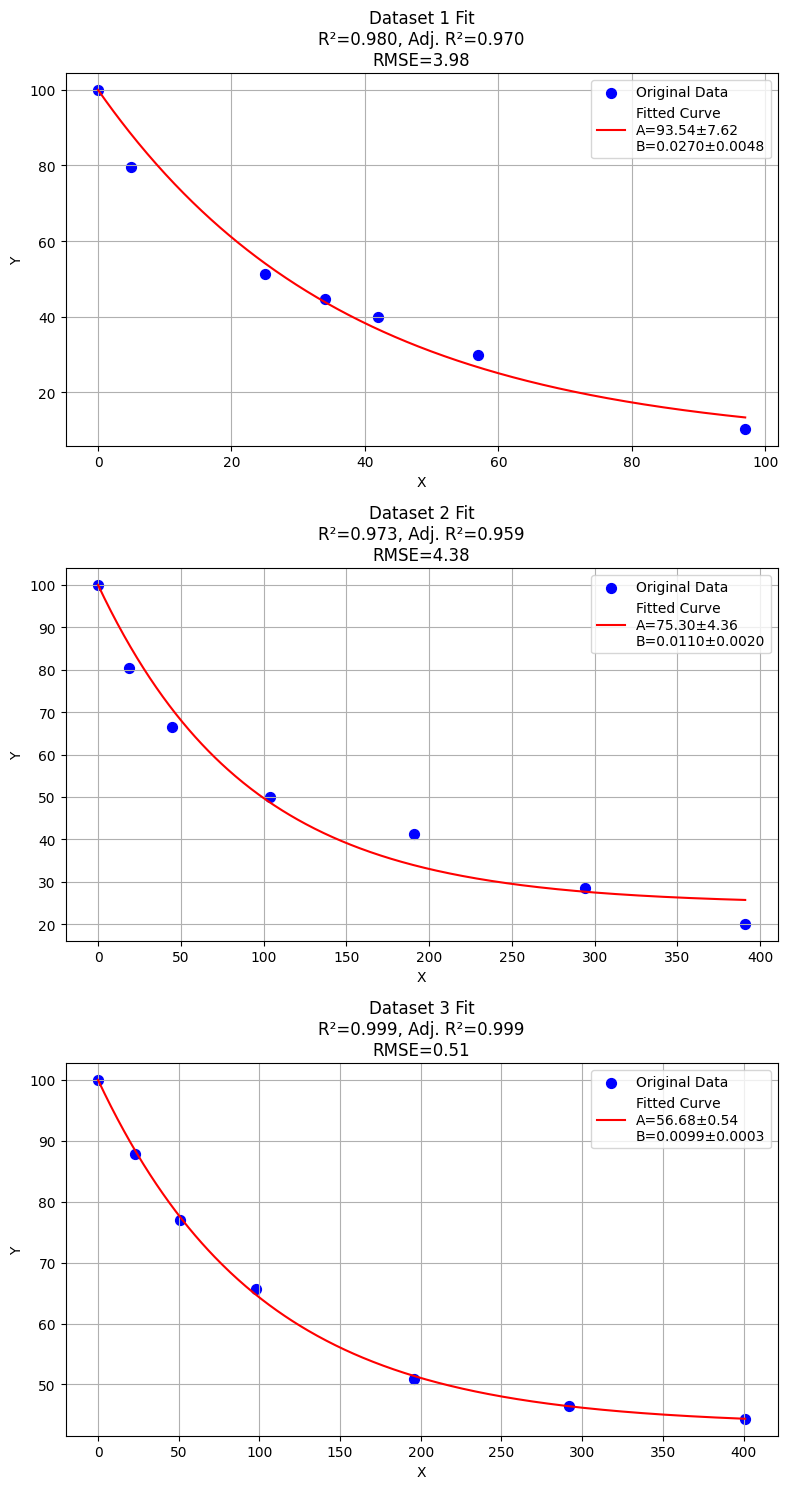

In [53]:
# 4. Plotting the results
plt.figure(figsize=(8, 15))

for i, res in enumerate(results):
    plt.subplot(len(results), 1, i + 1)
    plt.scatter(res["x_data"], res["y_data"], label="Original Data", color='blue', s=50)

    if "y_predicted" in res:
        # Create a smoother curve for plotting
        x_plot = np.linspace(min(res["x_data"]), max(res["x_data"]), 500)
        y_plot = custom_function(x_plot, res["A_fit"], res["B_fit"])
        plt.plot(x_plot, y_plot, color='red', label=f"Fitted Curve\nA={res['A_fit']:.2f}±{res['A_err']:.2f}\nB={res['B_fit']:.4f}±{res['B_err']:.4f}")
        
        if not np.isnan(res['adjusted_r_squared']):
            plt.title(f"{res['name']} Fit\nR²={res['r_squared']:.3f}, Adj. R²={res['adjusted_r_squared']:.3f}\nRMSE={res['rmse']:.2f}")
        else:
            plt.title(f"{res['name']} Fit\nR²={res['r_squared']:.3f}, RMSE={res['rmse']:.2f}\nAdj. R²: N/A")
    else:
        plt.title(f"{res['name']} (Fit Error)")
        plt.text(0.5, 0.5, f"Error: {res['error']}", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='red')

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


## Example 2. Non-Linear Example with Y-axis Errors with Negligible Standard Deviation for the First Point

Here we assume that the Y-value for x=0 should be equal to 100, so the error for this y data point is close to zero. For the remaining points, we expect errors to be the same and equal to 0.5. Thus, standard deviation is $\sigma_{i} = 0.5$ for each data point except the first one.

We set `sigma` array as `[1e-9, 0.5, 0.5, 0.5, ...]`. The first point with `sigma = 1e-9` gets an extremely large weight, forcing the fitted curve to pass almost exactly through that point. This value is chosen to be practically zero, thereby assigning an exceptionally large weight to this data point in the minimization process, compelling the fitted curve to pass almost exactly through $(x_1, y_1)$.

Based on the results, we will see why it was a bad idea to set negligible value of the standard deviation for the first point.

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error

In [55]:
# 1. Define the function to fit
def custom_function(x, A, B):
    """
    The custom function to approximate the data.
    f(x; A, B) = A * (np.exp(-B * x) - 1) + 100
    """
    return A * (np.exp(-B * x) - 1) + 100

In [56]:
# 2. Prepare the datasets
# Dataset 1
data1_x = np.array([0, 5, 25, 34, 42, 57, 97])
data1_y = np.array([100, 79.7, 51.3, 44.6, 39.8, 29.9, 10.3])

# Dataset 2
data2_x = np.array([0, 19, 45, 104, 191, 294, 391])
data2_y = np.array([100, 80.4, 66.4, 50.1, 41.2, 28.5, 20.1])

# Dataset 3
data3_x = np.array([0, 23, 51, 98, 196, 292, 401])
data3_y = np.array([100, 87.8, 77, 65.7, 50.9, 46.5, 44.4])

# Combine datasets into a list for easier iteration
datasets = [
    {"name": "Dataset 1", "x": data1_x, "y": data1_y},
    {"name": "Dataset 2", "x": data2_x, "y": data2_y},
    {"name": "Dataset 3", "x": data3_x, "y": data3_y},
]

In [57]:
# 3. Perform curve fitting and analysis for each dataset
results = []

for i, dataset in enumerate(datasets):
    print(f"\n--- Fitting {dataset['name']} ---")
    x_data = dataset["x"]
    y_data = dataset["y"]

    # Define sigma for Weighted Least Squares
    # First point (Y=100) has no error, assign a very small sigma to give it high weight
    # Other points have an error of +/- 0.5
    sigma = np.full_like(y_data, 0.5, dtype=float)
    sigma[0] = 1e-9  # Very small error for the first point
    print(f"Sigma for {dataset['name']}: {sigma}")


    # Initial guess for parameters A and B
    initial_guess = [50, 0.01]

    try:
        # curve_fit returns:
        # popt: Optimal values for the parameters so that the sum of the squared residuals is minimized.
        # pcov: The estimated covariance of popt.
        # Use sigma for weighted least squares
        popt, pcov = curve_fit(custom_function, x_data, y_data, p0=initial_guess, sigma=sigma, absolute_sigma=True)
        A_fit, B_fit = popt

        # Calculate standard errors from the covariance matrix
        perr = np.sqrt(np.diag(pcov))
        A_err, B_err = perr

        print(f"Fitted parameters: A = {A_fit:.4f} +/- {A_err:.4f}, B = {B_fit:.4f} +/- {B_err:.4f}")

        # Check condition number of the covariance matrix
        print(f"Condition number of the covariance matrix: {np.linalg.cond(pcov):.2f}")

        # Generate predicted y values using the fitted function
        y_predicted = custom_function(x_data, A_fit, B_fit)

        # Calculate metrics
        # Sum of Squared Residuals (SSR)
        ssr = np.sum((y_data - y_predicted)**2)
        print(f"Sum of Squared Residuals (SSR): {ssr:.4f}")

        # Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_data, y_predicted))
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

        # Total Sum of Squares (SST)
        y_mean = np.mean(y_data)
        sst = np.sum((y_data - y_mean)**2)
        print(f"Total Sum of Squares (TSS): {sst:.4f}")

        # R-squared (Coefficient of Determination)
        r_squared = r2_score(y_data, y_predicted)
        print(f"R-squared: {r_squared:.4f}")

        # Adjusted R-squared calculation
        n = len(x_data) # Number of data points
        k = len(popt)  # Number of parameters (A, B)
        if (n - k - 1) > 0:
            adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)
            print(f"Adjusted R-squared: {adjusted_r_squared:.4f}")
        else:
            adjusted_r_squared = np.nan
            print("Adjusted R-squared: Not applicable (insufficient degrees of freedom)")

        # Chi-Squared and Reduced Chi-Squared Calculation
        # Degrees of freedom (nu)
        nu = n - k
        if nu > 0:
            # Chi-squared (weighted sum of squared residuals)
            chi_squared = np.sum(((y_data - y_predicted) / sigma)**2)
            print(fr"Chi-Squared ($\chi^2$): {chi_squared:.4f}")

            # Reduced Chi-squared
            reduced_chi_squared = chi_squared / nu
            print(fr"Reduced Chi-Squared ($\chi^2_{{red}}$): {reduced_chi_squared:.4f}")
        else:
            chi_squared = np.nan
            reduced_chi_squared = np.nan
            print("Chi-Squared: Not applicable (insufficient degrees of freedom)")

        Value_for_x_0 = custom_function(0, A_fit, B_fit)
        print(f"Value for x=0 (Expected value is 100): {Value_for_x_0:.4f}")

        results.append({
            "name": dataset["name"],
            "x_data": x_data,
            "y_data": y_data,
            "y_predicted": y_predicted,
            "A_fit": A_fit,
            "B_fit": B_fit,
            "A_err": A_err,
            "B_err": B_err,
            "ssr": ssr,
            "rmse": rmse,
            "r_squared": r_squared,
            "adjusted_r_squared": adjusted_r_squared,
            "chi_squared": chi_squared,
            "reduced_chi_squared": reduced_chi_squared
        })

    except RuntimeError as e:
        print(f"Error: Could not fit curve for {dataset['name']}. {e}")
        results.append({
            "name": dataset["name"],
            "x_data": x_data,
            "y_data": y_data,
            "error": str(e)
        })



--- Fitting Dataset 1 ---
Sigma for Dataset 1: [1.e-09 5.e-01 5.e-01 5.e-01 5.e-01 5.e-01 5.e-01]
Fitted parameters: A = 93.5355 +/- 0.8080, B = 0.0270 +/- 0.0005
Condition number of the covariance matrix: 17123879.75
Sum of Squared Residuals (SSR): 111.1352
Root Mean Squared Error (RMSE): 3.9845
Total Sum of Squares (TSS): 5492.6000
R-squared: 0.9798
Adjusted R-squared: 0.9696
Chi-Squared ($\chi^2$): 444.5407
Reduced Chi-Squared ($\chi^2_{red}$): 88.9081
Value for x=0 (Expected value is 100): 100.0000

--- Fitting Dataset 2 ---
Sigma for Dataset 2: [1.e-09 5.e-01 5.e-01 5.e-01 5.e-01 5.e-01 5.e-01]
Fitted parameters: A = 75.2997 +/- 0.4209, B = 0.0110 +/- 0.0002
Condition number of the covariance matrix: 11211875.75
Sum of Squared Residuals (SSR): 134.1877
Root Mean Squared Error (RMSE): 4.3783
Total Sum of Squares (TSS): 4934.4171
R-squared: 0.9728
Adjusted R-squared: 0.9592
Chi-Squared ($\chi^2$): 536.7508
Reduced Chi-Squared ($\chi^2_{red}$): 107.3502
Value for x=0 (Expected value

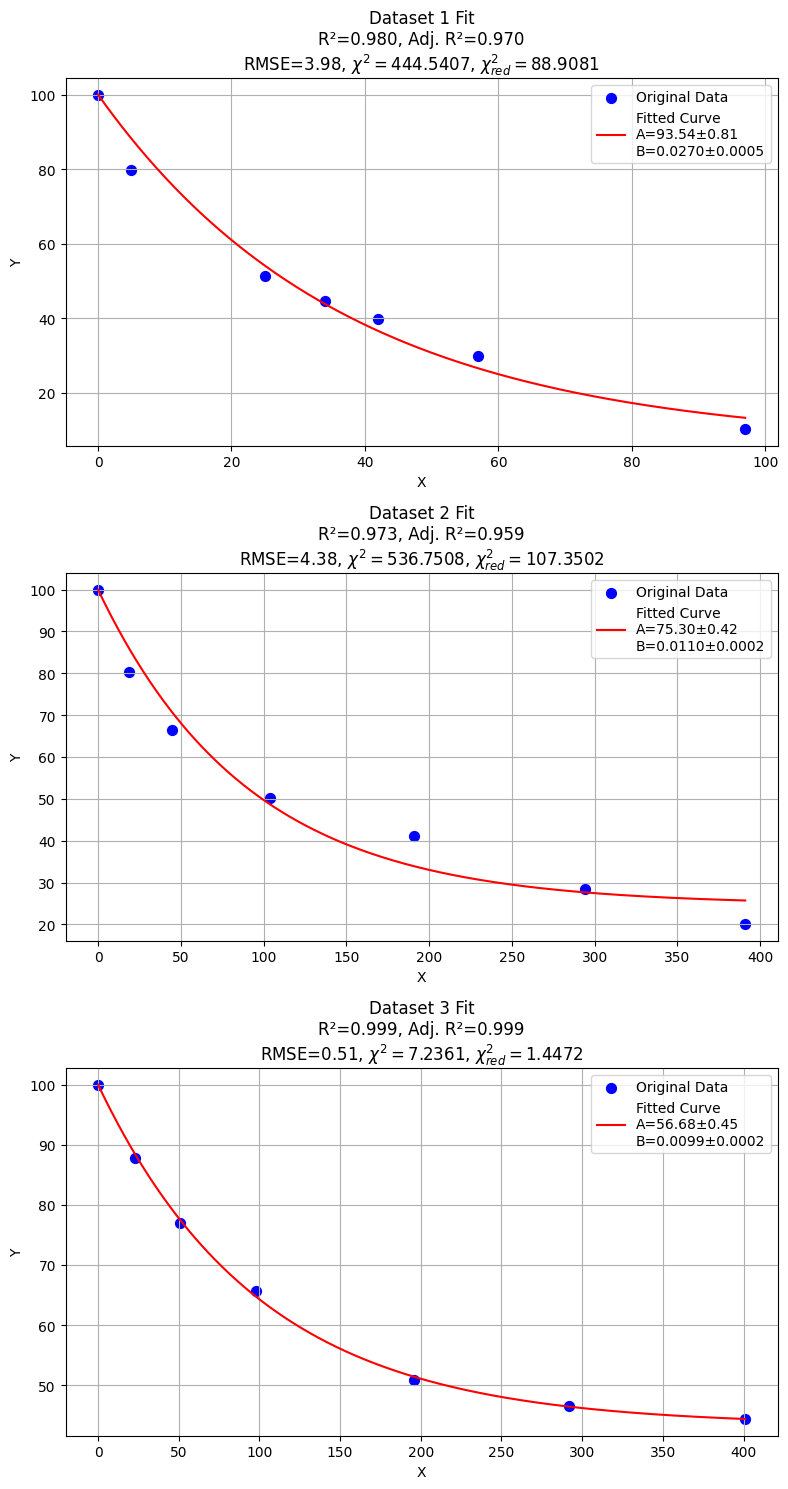

In [58]:
# 4. Plotting the results
plt.figure(figsize=(8, 15))

for i, res in enumerate(results):
    plt.subplot(len(results), 1, i + 1)
    plt.scatter(res["x_data"], res["y_data"], label="Original Data", color='blue', s=50)

    if "y_predicted" in res:
        x_plot = np.linspace(min(res["x_data"]), max(res["x_data"]), 500)
        y_plot = custom_function(x_plot, res["A_fit"], res["B_fit"])
        plt.plot(x_plot, y_plot, color='red', label=f"Fitted Curve\nA={res['A_fit']:.2f}±{res['A_err']:.2f}\nB={res['B_fit']:.4f}±{res['B_err']:.4f}")

        if not np.isnan(res['adjusted_r_squared']):
            plt.title(f"{res['name']} Fit\nR²={res['r_squared']:.3f}, Adj. R²={res['adjusted_r_squared']:.3f}\nRMSE={res['rmse']:.2f}, $\\chi^2={res['chi_squared']:.4f}$, $\\chi^2_{{red}}={res['reduced_chi_squared']:.4f}$")
        else:
            plt.title(f"{res['name']} Fit\nR²={res['r_squared']:.3f}, RMSE={res['rmse']:.2f}\nAdj. R²: N/A")
    else:
        plt.title(f"{res['name']} (Fit Error)")
        plt.text(0.5, 0.5, f"Error: {res['error']}", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='red')

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Obtained value of $\chi^2$ and $\chi^2_{red}$ are too large.

The first guess is we get such a result because of the very small value of the standard deviation for the first point. It may increase $\chi^2$ and $\chi^2_{red}$ significantly. We will double-check this below and will find out that the reason for such a behavior is different.

However, even if we're sure that the first y-value should be equal to 100 with a very good accuracy when $x = 0$, that's not a good idea to assign a very small value of standard deviation for this first data point. The best choice in this case is to assign to the first data point the same value of standard deviation as for all other points (0.5 in our case).

Thus, `sigma` array should be `[0.5, 0.5, 0.5, 0.5, ...]` for all the data points. After you identify all the model parameters, you can find how close the first predicted value of $y$ is to 100.

## Additional Notes

Regardless of whether you provide `sigma` or not, `scipy.optimize.curve_fit` internally uses a **Levenberg-Marquardt algorithm** by default to find the parameters that minimize the sum of squared residuals.

The key difference when `sigma` is provided is *what* the Levenberg-Marquardt algorithm minimizes:

* **Without `sigma` (OLS):** It minimizes the ordinary sum of squared residuals: $\sum (y_i - f(x_i, \beta))^2$.
* **With `sigma` (WLS):** It minimizes the **weighted sum of squared residuals**: $\sum w_i (y_i - f(x_i, \beta))^2$, where $w_i = 1 / \sigma_i^2$.

The Levenberg-Marquardt algorithm is an iterative numerical optimization algorithm. It cleverly switches between a steepest descent method (when far from the minimum) and the Gauss-Newton method (when close to the minimum) to efficiently converge to the optimal parameter values. When `sigma` is provided, the function being minimized (the objective function) simply changes from the unweighted sum of squares to the weighted sum of squares, but the core optimization algorithm remains Levenberg-Marquardt.

You can actually specify other optimization algorithms for `curve_fit` using the `method` parameter (e.g., `'trf'` for Trust Region Reflective, or `'dogbox'` for dogleg algorithm), but Levenberg-Marquardt (`'lm'`) is the default and often a good choice for non-linear least squares problems. The concept of weighting applies similarly regardless of the specific algorithm used for minimization, as long as that algorithm supports minimizing a weighted sum of squares.

## Example 3. Non-Linear Example with Y-axis Errors

This time, `sigma` array is `[0.5, 0.5, 0.5, 0.5, ...]` for all the data points.

In [59]:
# 3. Perform curve fitting and analysis for each dataset
results = []

for i, dataset in enumerate(datasets):
    print(f"\n--- Fitting {dataset['name']} ---")
    x_data = dataset["x"]
    y_data = dataset["y"]

    # Define sigma for Weighted Least Squares
    # First point (Y=100) has no error, assign a very small sigma to give it high weight
    # Other points have an error of +/- 0.5
    sigma = np.full_like(y_data, 0.5, dtype=float)
    print(f"Sigma for {dataset['name']}: {sigma}")


    # Initial guess for parameters A and B
    initial_guess = [50, 0.01]

    try:
        # curve_fit returns:
        # popt: Optimal values for the parameters so that the sum of the squared residuals is minimized.
        # pcov: The estimated covariance of popt.
        # Use sigma for weighted least squares
        popt, pcov = curve_fit(custom_function, x_data, y_data, p0=initial_guess, sigma=sigma, absolute_sigma=True)
        A_fit, B_fit = popt

        # Calculate standard errors from the covariance matrix
        perr = np.sqrt(np.diag(pcov))
        A_err, B_err = perr

        print(f"Fitted parameters: A = {A_fit:.4f} +/- {A_err:.4f}, B = {B_fit:.4f} +/- {B_err:.4f}")

        # Check condition number of the covariance matrix
        print(f"Condition number of the covariance matrix: {np.linalg.cond(pcov):.2f}")

        # Generate predicted y values using the fitted function
        y_predicted = custom_function(x_data, A_fit, B_fit)

        # Calculate metrics
        # Sum of Squared Residuals (SSR)
        ssr = np.sum((y_data - y_predicted)**2)
        print(f"Sum of Squared Residuals (SSR): {ssr:.4f}")

        # Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_data, y_predicted))
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

        # Total Sum of Squares (SST)
        y_mean = np.mean(y_data)
        sst = np.sum((y_data - y_mean)**2)
        print(f"Total Sum of Squares (TSS): {sst:.4f}")

        # R-squared (Coefficient of Determination)
        r_squared = r2_score(y_data, y_predicted)
        print(f"R-squared: {r_squared:.4f}")

        # Adjusted R-squared calculation
        n = len(x_data) # Number of data points
        k = len(popt)  # Number of parameters (A, B)
        if (n - k - 1) > 0:
            adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)
            print(f"Adjusted R-squared: {adjusted_r_squared:.4f}")
        else:
            adjusted_r_squared = np.nan
            print("Adjusted R-squared: Not applicable (insufficient degrees of freedom)")

        # Chi-Squared and Reduced Chi-Squared Calculation
        # Degrees of freedom (nu)
        nu = n - k
        if nu > 0:
            # Chi-squared (weighted sum of squared residuals)
            chi_squared = np.sum(((y_data - y_predicted) / sigma)**2)
            print(fr"Chi-Squared ($\chi^2$): {chi_squared:.4f}")

            # Reduced Chi-squared
            reduced_chi_squared = chi_squared / nu
            print(fr"Reduced Chi-Squared ($\chi^2_{{red}}$): {reduced_chi_squared:.4f}")
        else:
            chi_squared = np.nan
            reduced_chi_squared = np.nan
            print("Chi-Squared: Not applicable (insufficient degrees of freedom)")

        Value_for_x_0 = custom_function(0, A_fit, B_fit)
        print(f"Value for x=0 (Expected value is 100): {Value_for_x_0:.4f}")

        results.append({
            "name": dataset["name"],
            "x_data": x_data,
            "y_data": y_data,
            "y_predicted": y_predicted,
            "A_fit": A_fit,
            "B_fit": B_fit,
            "A_err": A_err,
            "B_err": B_err,
            "ssr": ssr,
            "rmse": rmse,
            "r_squared": r_squared,
            "adjusted_r_squared": adjusted_r_squared,
            "chi_squared": chi_squared,
            "reduced_chi_squared": reduced_chi_squared
        })

    except RuntimeError as e:
        print(f"Error: Could not fit curve for {dataset['name']}. {e}")
        results.append({
            "name": dataset["name"],
            "x_data": x_data,
            "y_data": y_data,
            "error": str(e)
        })



--- Fitting Dataset 1 ---
Sigma for Dataset 1: [0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Fitted parameters: A = 93.5355 +/- 0.8080, B = 0.0270 +/- 0.0005
Condition number of the covariance matrix: 17123879.75
Sum of Squared Residuals (SSR): 111.1352
Root Mean Squared Error (RMSE): 3.9845
Total Sum of Squares (TSS): 5492.6000
R-squared: 0.9798
Adjusted R-squared: 0.9696
Chi-Squared ($\chi^2$): 444.5407
Reduced Chi-Squared ($\chi^2_{red}$): 88.9081
Value for x=0 (Expected value is 100): 100.0000

--- Fitting Dataset 2 ---
Sigma for Dataset 2: [0.5 0.5 0.5 0.5 0.5 0.5 0.5]
Fitted parameters: A = 75.2997 +/- 0.4209, B = 0.0110 +/- 0.0002
Condition number of the covariance matrix: 11211875.75
Sum of Squared Residuals (SSR): 134.1877
Root Mean Squared Error (RMSE): 4.3783
Total Sum of Squares (TSS): 4934.4171
R-squared: 0.9728
Adjusted R-squared: 0.9592
Chi-Squared ($\chi^2$): 536.7508
Reduced Chi-Squared ($\chi^2_{red}$): 107.3502
Value for x=0 (Expected value is 100): 100.0000

--- Fitting Dataset 3 

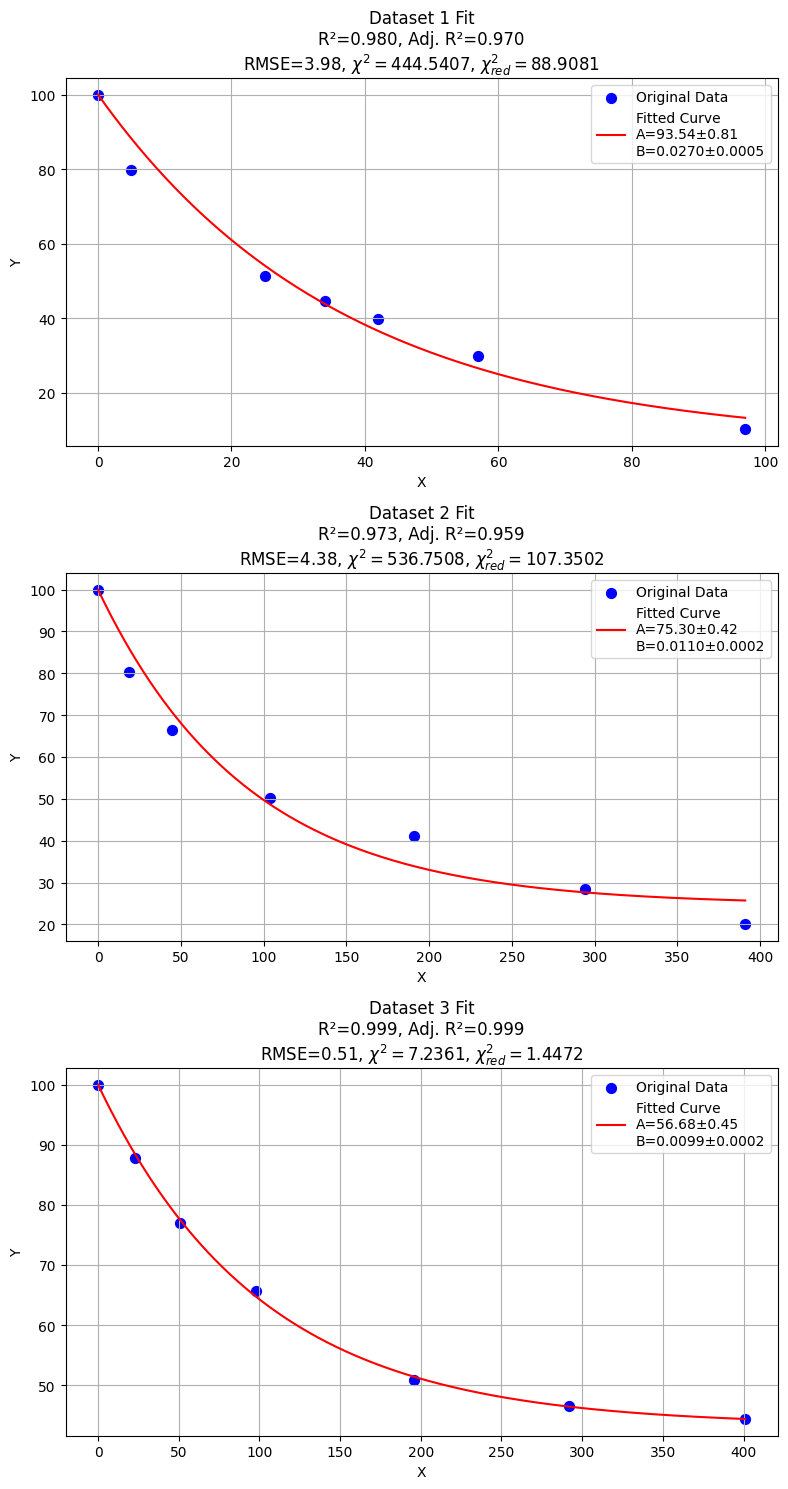

In [60]:
# 4. Plotting the results
plt.figure(figsize=(8, 15))

for i, res in enumerate(results):
    plt.subplot(len(results), 1, i + 1)
    plt.scatter(res["x_data"], res["y_data"], label="Original Data", color='blue', s=50)

    if "y_predicted" in res:
        x_plot = np.linspace(min(res["x_data"]), max(res["x_data"]), 500)
        y_plot = custom_function(x_plot, res["A_fit"], res["B_fit"])
        plt.plot(x_plot, y_plot, color='red', label=f"Fitted Curve\nA={res['A_fit']:.2f}±{res['A_err']:.2f}\nB={res['B_fit']:.4f}±{res['B_err']:.4f}")

        if not np.isnan(res['adjusted_r_squared']):
            plt.title(f"{res['name']} Fit\nR²={res['r_squared']:.3f}, Adj. R²={res['adjusted_r_squared']:.3f}\nRMSE={res['rmse']:.2f}, $\\chi^2={res['chi_squared']:.4f}$, $\\chi^2_{{red}}={res['reduced_chi_squared']:.4f}$")
        else:
            plt.title(f"{res['name']} Fit\nR²={res['r_squared']:.3f}, RMSE={res['rmse']:.2f}\nAdj. R²: N/A")
    else:
        plt.title(f"{res['name']} (Fit Error)")
        plt.text(0.5, 0.5, f"Error: {res['error']}", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='red')

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

### Analysis of the results

The results are totally the same as in the previous case.

It's clear that for dataset 1 and dataset 2 the results of our analysis show that the selected function doesn't fit the data well enough:
* RMSE is too high
* $\chi^2_{red}$ is too high

Thus, we need to look for another custom function for the datasets 1 and 2.

For the dataset 3:

* **Reduced Chi-Squared ($\chi^2_{red}$):** This is a measure of the **goodness-of-fit relative to our assumed measurement errors**. It normalizes the residuals by the standard deviation of the measurements ($\sigma_i$). A value close to 1 means the observed scatter of our data points around the fit is consistent with our assumed uncertainties.
    * Since $\chi^2_{red}$ is 1.4472 (greater than 1), it suggests that the scatter in our data is **larger than what we expected** based on our assumed standard deviation of 0.5. This implies that we have likely **underestimated the true measurement uncertainty**.

* **Root Mean Squared Error (RMSE):** This is an **estimate of the standard deviation of the residuals**. The fact that our RMSE (0.5084) is very close to our assumed $\sigma_i$ of 0.5 is a common occurrence and shows that our model is fitting the data well. However, because the reduced chi-squared is greater than 1, it tells us that the true underlying noise in the data is likely a bit larger than 0.5, even if the RMSE is close to that value. The $\chi^2_{red}$ is a more robust statistical tool for validating our assumption about the uncertainty of our measurements.

Let's try to increase the standard deviations from 0.5 to 1.0.

### Usage of the Higher Value of Errors

In [61]:
# 3. Perform curve fitting and analysis for each dataset
results = []

for i, dataset in enumerate(datasets):
    print(f"\n--- Fitting {dataset['name']} ---")
    x_data = dataset["x"]
    y_data = dataset["y"]

    # Define sigma for Weighted Least Squares
    # First point (Y=100) has no error, assign a very small sigma to give it high weight
    # Other points have an error of +/- 0.5
    sigma = np.full_like(y_data, 1.0, dtype=float) # UPDATE from 0.5 to 1.0
    print(f"Sigma for {dataset['name']}: {sigma}")


    # Initial guess for parameters A and B
    initial_guess = [50, 0.01]

    try:
        # curve_fit returns:
        # popt: Optimal values for the parameters so that the sum of the squared residuals is minimized.
        # pcov: The estimated covariance of popt.
        # Use sigma for weighted least squares
        popt, pcov = curve_fit(custom_function, x_data, y_data, p0=initial_guess, sigma=sigma, absolute_sigma=True)
        A_fit, B_fit = popt

        # Calculate standard errors from the covariance matrix
        perr = np.sqrt(np.diag(pcov))
        A_err, B_err = perr

        print(f"Fitted parameters: A = {A_fit:.4f} +/- {A_err:.4f}, B = {B_fit:.4f} +/- {B_err:.4f}")

        # Check condition number of the covariance matrix
        print(f"Condition number of the covariance matrix: {np.linalg.cond(pcov):.2f}")

        # Generate predicted y values using the fitted function
        y_predicted = custom_function(x_data, A_fit, B_fit)

        # Calculate metrics
        # Sum of Squared Residuals (SSR)
        ssr = np.sum((y_data - y_predicted)**2)
        print(f"Sum of Squared Residuals (SSR): {ssr:.4f}")

        # Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_data, y_predicted))
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

        # Total Sum of Squares (SST)
        y_mean = np.mean(y_data)
        sst = np.sum((y_data - y_mean)**2)
        print(f"Total Sum of Squares (TSS): {sst:.4f}")

        # R-squared (Coefficient of Determination)
        r_squared = r2_score(y_data, y_predicted)
        print(f"R-squared: {r_squared:.4f}")

        # Adjusted R-squared calculation
        n = len(x_data) # Number of data points
        k = len(popt)  # Number of parameters (A, B)
        if (n - k - 1) > 0:
            adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)
            print(f"Adjusted R-squared: {adjusted_r_squared:.4f}")
        else:
            adjusted_r_squared = np.nan
            print("Adjusted R-squared: Not applicable (insufficient degrees of freedom)")

        # Chi-Squared and Reduced Chi-Squared Calculation
        # Degrees of freedom (nu)
        nu = n - k
        if nu > 0:
            # Chi-squared (weighted sum of squared residuals)
            chi_squared = np.sum(((y_data - y_predicted) / sigma)**2)
            print(fr"Chi-Squared ($\chi^2$): {chi_squared:.4f}")

            # Reduced Chi-squared
            reduced_chi_squared = chi_squared / nu
            print(fr"Reduced Chi-Squared ($\chi^2_{{red}}$): {reduced_chi_squared:.4f}")
        else:
            chi_squared = np.nan
            reduced_chi_squared = np.nan
            print("Chi-Squared: Not applicable (insufficient degrees of freedom)")

        Value_for_x_0 = custom_function(0, A_fit, B_fit)
        print(f"Value for x=0 (Expected value is 100): {Value_for_x_0:.4f}")

        results.append({
            "name": dataset["name"],
            "x_data": x_data,
            "y_data": y_data,
            "y_predicted": y_predicted,
            "A_fit": A_fit,
            "B_fit": B_fit,
            "A_err": A_err,
            "B_err": B_err,
            "ssr": ssr,
            "rmse": rmse,
            "r_squared": r_squared,
            "adjusted_r_squared": adjusted_r_squared,
            "chi_squared": chi_squared,
            "reduced_chi_squared": reduced_chi_squared
        })

    except RuntimeError as e:
        print(f"Error: Could not fit curve for {dataset['name']}. {e}")
        results.append({
            "name": dataset["name"],
            "x_data": x_data,
            "y_data": y_data,
            "error": str(e)
        })



--- Fitting Dataset 1 ---
Sigma for Dataset 1: [1. 1. 1. 1. 1. 1. 1.]
Fitted parameters: A = 93.5355 +/- 1.6160, B = 0.0270 +/- 0.0010
Condition number of the covariance matrix: 17123879.75
Sum of Squared Residuals (SSR): 111.1352
Root Mean Squared Error (RMSE): 3.9845
Total Sum of Squares (TSS): 5492.6000
R-squared: 0.9798
Adjusted R-squared: 0.9696
Chi-Squared ($\chi^2$): 111.1352
Reduced Chi-Squared ($\chi^2_{red}$): 22.2270
Value for x=0 (Expected value is 100): 100.0000

--- Fitting Dataset 2 ---
Sigma for Dataset 2: [1. 1. 1. 1. 1. 1. 1.]
Fitted parameters: A = 75.2997 +/- 0.8418, B = 0.0110 +/- 0.0004
Condition number of the covariance matrix: 11211875.75
Sum of Squared Residuals (SSR): 134.1877
Root Mean Squared Error (RMSE): 4.3783
Total Sum of Squares (TSS): 4934.4171
R-squared: 0.9728
Adjusted R-squared: 0.9592
Chi-Squared ($\chi^2$): 134.1877
Reduced Chi-Squared ($\chi^2_{red}$): 26.8375
Value for x=0 (Expected value is 100): 100.0000

--- Fitting Dataset 3 ---
Sigma for D

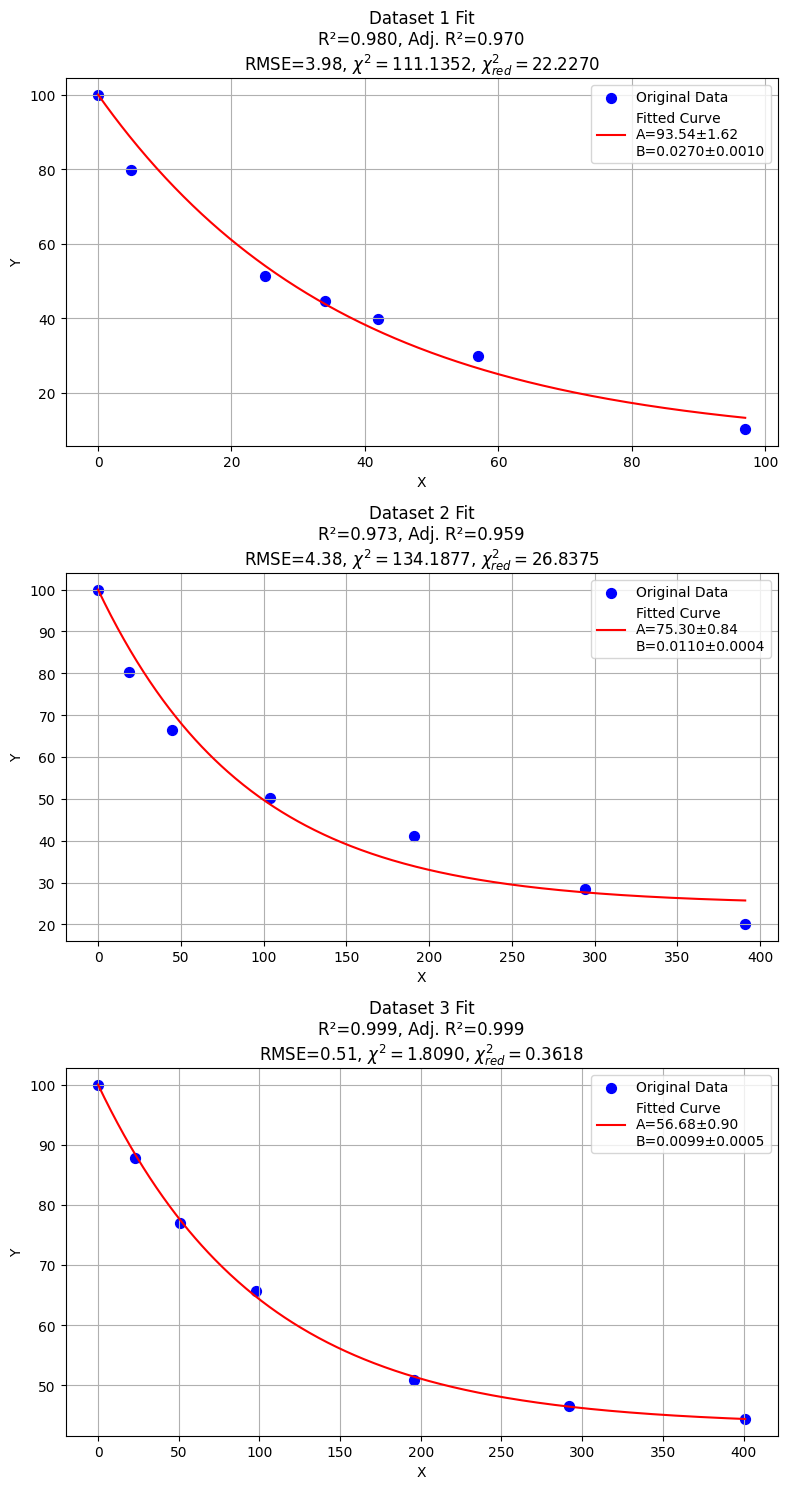

In [62]:
# 4. Plotting the results
plt.figure(figsize=(8, 15))

for i, res in enumerate(results):
    plt.subplot(len(results), 1, i + 1)
    plt.scatter(res["x_data"], res["y_data"], label="Original Data", color='blue', s=50)

    if "y_predicted" in res:
        x_plot = np.linspace(min(res["x_data"]), max(res["x_data"]), 500)
        y_plot = custom_function(x_plot, res["A_fit"], res["B_fit"])
        plt.plot(x_plot, y_plot, color='red', label=f"Fitted Curve\nA={res['A_fit']:.2f}±{res['A_err']:.2f}\nB={res['B_fit']:.4f}±{res['B_err']:.4f}")

        if not np.isnan(res['adjusted_r_squared']):
            plt.title(f"{res['name']} Fit\nR²={res['r_squared']:.3f}, Adj. R²={res['adjusted_r_squared']:.3f}\nRMSE={res['rmse']:.2f}, $\\chi^2={res['chi_squared']:.4f}$, $\\chi^2_{{red}}={res['reduced_chi_squared']:.4f}$")
        else:
            plt.title(f"{res['name']} Fit\nR²={res['r_squared']:.3f}, RMSE={res['rmse']:.2f}\nAdj. R²: N/A")
    else:
        plt.title(f"{res['name']} (Fit Error)")
        plt.text(0.5, 0.5, f"Error: {res['error']}", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='red')

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Results for the dataset 1 and 2:
* RMSE is too high
* $\chi^2_{red}$ is too high

Results for the dataset 3:
* A reduced chi-squared value of 0.3618 is too low and indicates that we have overestimated the standard deviation of our measurements.
* Also, note that the errors for A and B parameters were increased afrer we increased

The standard deviation of 0.6 will make $\chi^2_{red}$ very close to 1 for the dataset 3 (see below)

In [63]:
# 3. Perform curve fitting and analysis for each dataset
results = []

for i, dataset in enumerate(datasets):
    print(f"\n--- Fitting {dataset['name']} ---")
    x_data = dataset["x"]
    y_data = dataset["y"]

    # Define sigma for Weighted Least Squares
    # First point (Y=100) has no error, assign a very small sigma to give it high weight
    # Other points have an error of +/- 0.5
    sigma = np.full_like(y_data, 0.6, dtype=float) # UPDATE from 1.0 to 0.6
    print(f"Sigma for {dataset['name']}: {sigma}")


    # Initial guess for parameters A and B
    initial_guess = [50, 0.01]

    try:
        # curve_fit returns:
        # popt: Optimal values for the parameters so that the sum of the squared residuals is minimized.
        # pcov: The estimated covariance of popt.
        # Use sigma for weighted least squares
        popt, pcov = curve_fit(custom_function, x_data, y_data, p0=initial_guess, sigma=sigma, absolute_sigma=True)
        A_fit, B_fit = popt

        # Calculate standard errors from the covariance matrix
        perr = np.sqrt(np.diag(pcov))
        A_err, B_err = perr

        print(f"Fitted parameters: A = {A_fit:.4f} +/- {A_err:.4f}, B = {B_fit:.4f} +/- {B_err:.4f}")

        # Check condition number of the covariance matrix
        print(f"Condition number of the covariance matrix: {np.linalg.cond(pcov):.2f}")

        # Generate predicted y values using the fitted function
        y_predicted = custom_function(x_data, A_fit, B_fit)

        # Calculate metrics
        # Sum of Squared Residuals (SSR)
        ssr = np.sum((y_data - y_predicted)**2)
        print(f"Sum of Squared Residuals (SSR): {ssr:.4f}")

        # Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_data, y_predicted))
        print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

        # Total Sum of Squares (SST)
        y_mean = np.mean(y_data)
        sst = np.sum((y_data - y_mean)**2)
        print(f"Total Sum of Squares (TSS): {sst:.4f}")

        # R-squared (Coefficient of Determination)
        r_squared = r2_score(y_data, y_predicted)
        print(f"R-squared: {r_squared:.4f}")

        # Adjusted R-squared calculation
        n = len(x_data) # Number of data points
        k = len(popt)  # Number of parameters (A, B)
        if (n - k - 1) > 0:
            adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)
            print(f"Adjusted R-squared: {adjusted_r_squared:.4f}")
        else:
            adjusted_r_squared = np.nan
            print("Adjusted R-squared: Not applicable (insufficient degrees of freedom)")

        # Chi-Squared and Reduced Chi-Squared Calculation
        # Degrees of freedom (nu)
        nu = n - k
        if nu > 0:
            # Chi-squared (weighted sum of squared residuals)
            chi_squared = np.sum(((y_data - y_predicted) / sigma)**2)
            print(fr"Chi-Squared ($\chi^2$): {chi_squared:.4f}")

            # Reduced Chi-squared
            reduced_chi_squared = chi_squared / nu
            print(fr"Reduced Chi-Squared ($\chi^2_{{red}}$): {reduced_chi_squared:.4f}")
        else:
            chi_squared = np.nan
            reduced_chi_squared = np.nan
            print("Chi-Squared: Not applicable (insufficient degrees of freedom)")

        Value_for_x_0 = custom_function(0, A_fit, B_fit)
        print(f"Value for x=0 (Expected value is 100): {Value_for_x_0:.4f}")

        results.append({
            "name": dataset["name"],
            "x_data": x_data,
            "y_data": y_data,
            "y_predicted": y_predicted,
            "A_fit": A_fit,
            "B_fit": B_fit,
            "A_err": A_err,
            "B_err": B_err,
            "ssr": ssr,
            "rmse": rmse,
            "r_squared": r_squared,
            "adjusted_r_squared": adjusted_r_squared,
            "chi_squared": chi_squared,
            "reduced_chi_squared": reduced_chi_squared
        })

    except RuntimeError as e:
        print(f"Error: Could not fit curve for {dataset['name']}. {e}")
        results.append({
            "name": dataset["name"],
            "x_data": x_data,
            "y_data": y_data,
            "error": str(e)
        })



--- Fitting Dataset 1 ---
Sigma for Dataset 1: [0.6 0.6 0.6 0.6 0.6 0.6 0.6]
Fitted parameters: A = 93.5355 +/- 0.9696, B = 0.0270 +/- 0.0006
Condition number of the covariance matrix: 17123881.30
Sum of Squared Residuals (SSR): 111.1352
Root Mean Squared Error (RMSE): 3.9845
Total Sum of Squares (TSS): 5492.6000
R-squared: 0.9798
Adjusted R-squared: 0.9696
Chi-Squared ($\chi^2$): 308.7088
Reduced Chi-Squared ($\chi^2_{red}$): 61.7418
Value for x=0 (Expected value is 100): 100.0000

--- Fitting Dataset 2 ---
Sigma for Dataset 2: [0.6 0.6 0.6 0.6 0.6 0.6 0.6]
Fitted parameters: A = 75.2997 +/- 0.5051, B = 0.0110 +/- 0.0002
Condition number of the covariance matrix: 11211875.26
Sum of Squared Residuals (SSR): 134.1877
Root Mean Squared Error (RMSE): 4.3783
Total Sum of Squares (TSS): 4934.4171
R-squared: 0.9728
Adjusted R-squared: 0.9592
Chi-Squared ($\chi^2$): 372.7436
Reduced Chi-Squared ($\chi^2_{red}$): 74.5487
Value for x=0 (Expected value is 100): 100.0000

--- Fitting Dataset 3 -

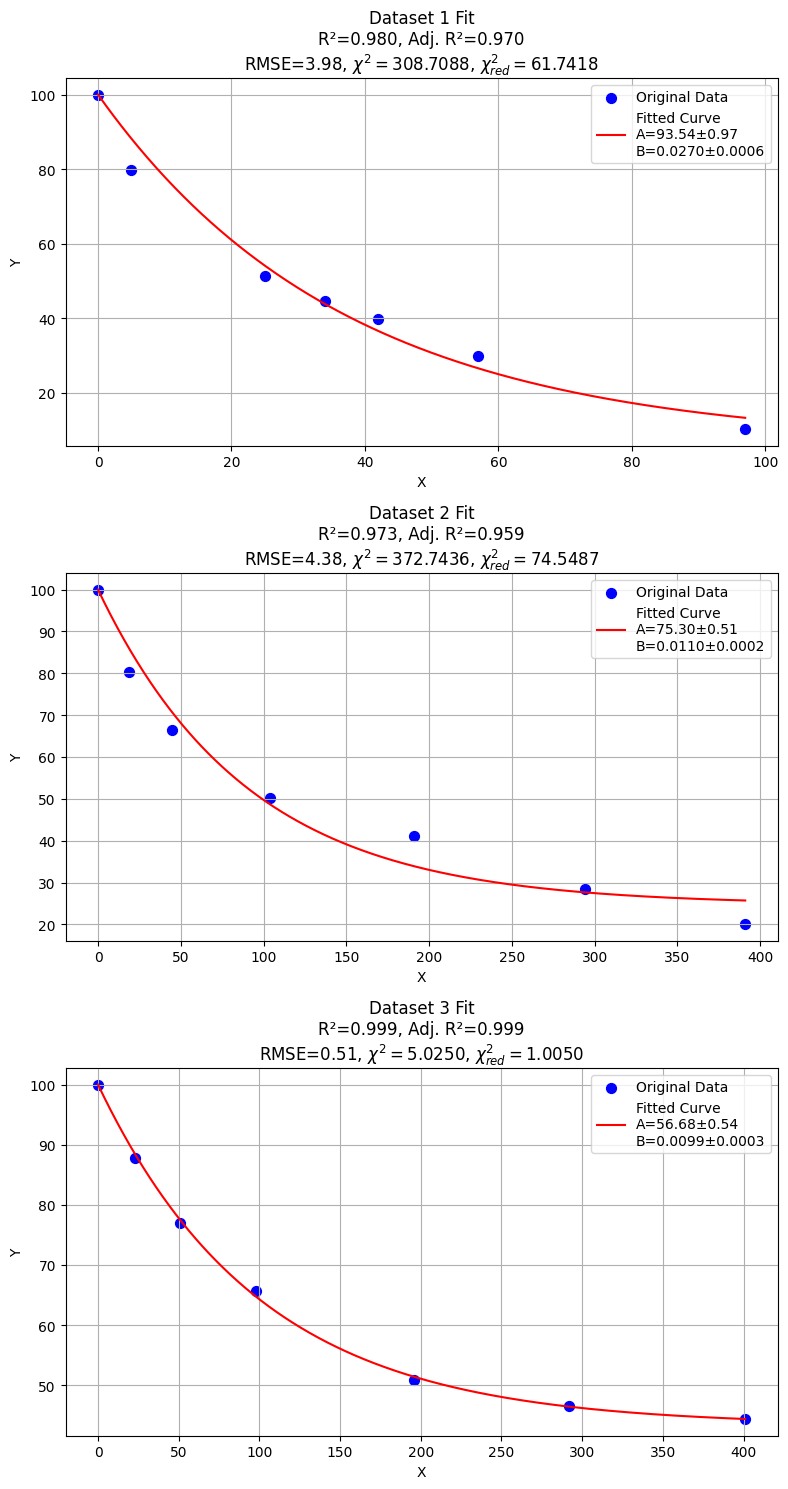

In [64]:
# 4. Plotting the results
plt.figure(figsize=(8, 15))

for i, res in enumerate(results):
    plt.subplot(len(results), 1, i + 1)
    plt.scatter(res["x_data"], res["y_data"], label="Original Data", color='blue', s=50)

    if "y_predicted" in res:
        x_plot = np.linspace(min(res["x_data"]), max(res["x_data"]), 500)
        y_plot = custom_function(x_plot, res["A_fit"], res["B_fit"])
        plt.plot(x_plot, y_plot, color='red', label=f"Fitted Curve\nA={res['A_fit']:.2f}±{res['A_err']:.2f}\nB={res['B_fit']:.4f}±{res['B_err']:.4f}")

        if not np.isnan(res['adjusted_r_squared']):
            plt.title(f"{res['name']} Fit\nR²={res['r_squared']:.3f}, Adj. R²={res['adjusted_r_squared']:.3f}\nRMSE={res['rmse']:.2f}, $\\chi^2={res['chi_squared']:.4f}$, $\\chi^2_{{red}}={res['reduced_chi_squared']:.4f}$")
        else:
            plt.title(f"{res['name']} Fit\nR²={res['r_squared']:.3f}, RMSE={res['rmse']:.2f}\nAdj. R²: N/A")
    else:
        plt.title(f"{res['name']} (Fit Error)")
        plt.text(0.5, 0.5, f"Error: {res['error']}", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='red')

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()